# Jupyter Notebook companion to Lyapunov paper

This notebook contains all of the code necessary for performing the computations in the second part of section III.

## Imports

The following Python packages are necessary for producing the figures in the paper.

In [1]:
import imgtda
from imgtda import standard_analysis as sa
from imgtda import computer_vision as cv
from imgtda import locally_striped as ls
from imgtda.locally_striped import defect_analysis as da

import numpy as np
import scipy
from scipy import misc
from skimage import morphology as morph
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Environment Variables

The following variables should be modified so they point to the user's local directory for performing any computations.

In [2]:
# Container dictionary for environment variables and other user-defined settings
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_data':'g21per/bmps_abs_val/%05d.bmp',
                                'lyap_stats_plots_out':'g21flow/independence_analysis/2017_11_18_pr_curves/',
                                'process_range': range(100,105),
                               }

# Rename variables for ease of use
process_range = myproject['additional_data']['process_range']

# Sample index for processing single image for illustration purposes
idx = process_range[0]

# Global parameter values for running defect computations
delta = 10  # Noise threshold on persistence diagram
sigma = 3   # Smoothing for generating topological defects
radius = 10 # Radius for dilating point defects

## Utility Functions

These functions are all supporting functions dealing with data I/O or generic data conditioning.

In [3]:
def load_image_data(project, idx):
    """Load the temperature field and associated persistence data from files."""
    
    im = ls.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    
    return im

def get_topological_defects(im, sigma):
    
    im.generate_orientation_field(sigma,1)
    im.orientation_fields[sigma].topological_defects_list = sa.topological_defect_array_to_dataframe(
        im.orientation_fields[sigma].topological_defects)
    
    return im

def load_lyap_data(project, idx):
    """Load the lyapunov image data from files."""
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_data'] % idx))
    return lyap

def cropping_region():
    """Generate the cropping region for computing P/R curves."""

    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)
    return c


## Temperature Field Annotations

The following code is used to identify a particular defect type or other region of interest (e.g. local wavenumber) from the temperature field. All of these annotations are performed directly from the temperature field. 

### Canonical Defect Classifications

The following code will identify canonical patterns such as:
- Convex or Concave Disclination
- Dislocation Pair
- Grain Boundary
- Target
- Spiral

In [4]:
def get_canonical_defects(im, sigma, radius, delta):
    
    im = get_topological_defects(im, sigma)
    im.get_persistent_h1_generators(delta)
    im.classify_defects(sigma,radius,'serial')
    
    return im

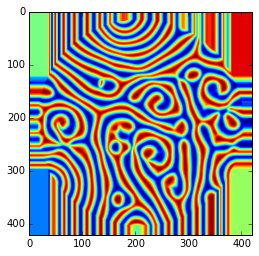

target


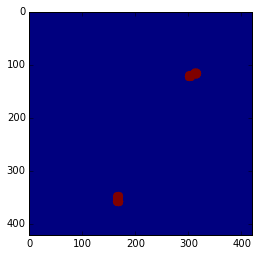

disclination-concave


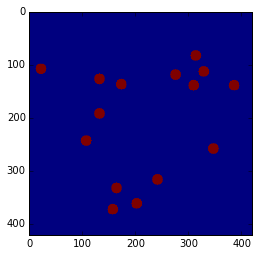

disclination-convex


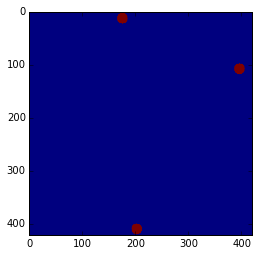

grain boundary


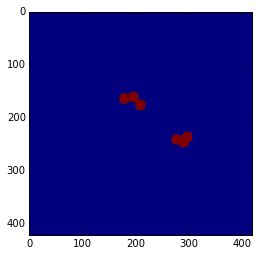

spiral


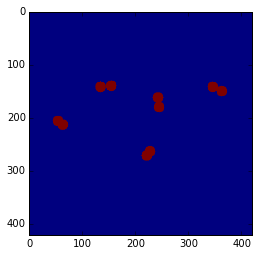

dislocation pair


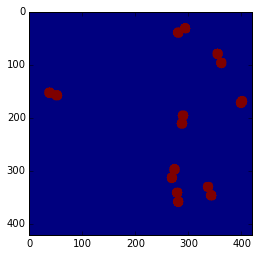

In [5]:
im = load_image_data(myproject, idx)

im = get_canonical_defects(im, sigma, radius, delta)


# Plot the temperature field and its identified canonical defects
plt.imshow(im.bmp)
plt.show()

for key, value in im.defect_regions.iteritems():
    print key
    plt.imshow(im.defect_regions[key])
    plt.show()

### Classical Physics Computations

The following code will identify places in the temperature field with e.g. high or low local wavenumber, or the Eulerian derivatives.

#### Local Wavenumber

In [6]:
def get_local_wavenumber(im):
    
    im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.
    
    return im

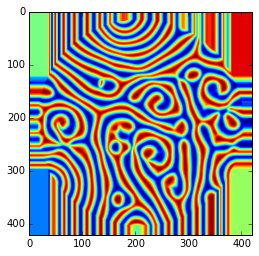

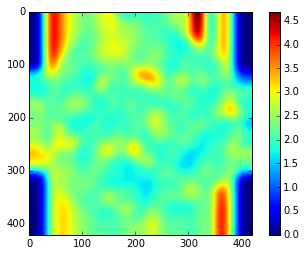

In [7]:
im = load_image_data(myproject, idx)

im = get_local_wavenumber(im)


# Plot the temperature field and the local wavenumber
plt.imshow(im.bmp)
plt.show()
plt.imshow(im.local_wavenumber)
plt.colorbar()
plt.show()


#### Eulerian Derivatives

In [8]:
def compute_derivative(images, derivative):
    if derivative == 1:
        return abs(images[0] - images[1])  
    else: 
        return compute_derivative([compute_derivative(images,derivative-1), 
                                   compute_derivative(images[1:],derivative-1)],1)

def get_derivatives(im, derivatives):
    
    im.derivative = {}
    for derivative in derivatives:
        im.derivative[derivative] = compute_derivative(im.prev_imgs, derivative)

    return im
    

In [9]:
im = load_image_data(myproject, idx)

# Number of derivatives to compute
num_derivatives = 3

# Set up initial values and populate list of previous images
derivatives = range(1, num_derivatives+1)

im.prev_imgs = range(num_derivatives+1)
im.prev_imgs[0] = im.bmp.copy().astype(np.float)

for derivative in derivatives:
    im.prev_imgs[derivative] =  load_image_data(myproject, idx - derivative).bmp.copy().astype(np.float)

# Compute derivatives
im = get_derivatives(im, derivatives)

Derivative 1


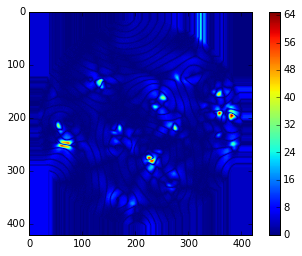

Derivative 2


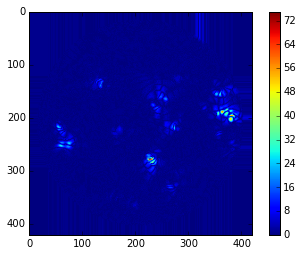

Derivative 3


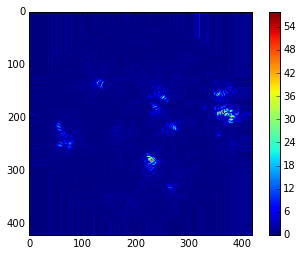

In [10]:
for derivative in derivatives:
    print "Derivative %d" % derivative
    plt.imshow(im.derivative[derivative])
    plt.colorbar()
    plt.show()

### Transient Defect Annotations

e.g. Roll pinch-off points (saddles), emerging targets (local extrema).

#### Roll pinch-offs and Emerging Targets

In [11]:
def get_pinch_offs(im, lowercutoff, uppercutoff, delta, radius):
    
    im.pinch_offs = da.get_pinch_offs(im, lowercutoff, uppercutoff, delta)
    im.pinch_offs = morph.dilation(im.pinch_offs, morph.disk(radius))
    
    return im

def get_emerging_targets(im, lowercutoff, uppercutoff, delta, radius):
    
    im.emerging_targets = da.get_emerging_targets(im, lowercutoff, uppercutoff, delta)
    im.emerging_targets = morph.dilation(im.emerging_targets, morph.disk(radius))
    
    return im


In [12]:
lowercutoff = 50
uppercutoff = 200

delta = 10

im = load_image_data(myproject, idx)


# Get pinch-offs and emerging targets
im = get_pinch_offs(im, lowercutoff, uppercutoff, delta, radius)
im = get_emerging_targets(im, lowercutoff, uppercutoff, delta, radius)


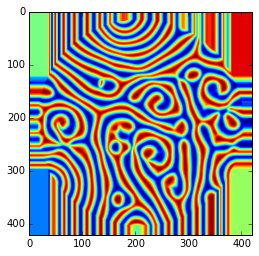

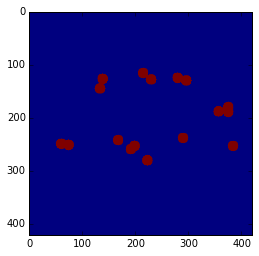

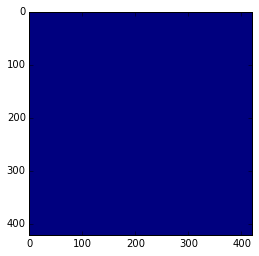

In [13]:
# Plot the temperature field and the pinch-offs/emerging targets

plt.imshow( im.bmp )
plt.show()

plt.imshow(im.pinch_offs)
plt.show()

plt.imshow( im.emerging_targets )
plt.show()

#### Topological Defects with Velocity

In [14]:
def get_td_velocities(current, prior, distance_cutoff):
    
    types = [1., -1.]
    
    current['velocity'] = distance_cutoff  # Initialize unmatched to high velocity
    current['matchedid'] = -1
    
    if not prior.empty:  # Check to see if there are points to match to
        for t in types:
            type_matches = cv.match_points(current.ix[current.type == t,['row', 'col']], 
                                           prior.loc[prior.type == t,['row', 'col']], 
                                           distance_cutoff)
            current.ix[current.type==t, 'velocity'] = type_matches[:,1]
            current.ix[current.type==t, 'matchedid'] = type_matches[:,0].astype(np.int)
            
    return current

def get_high_velocity_pts(im, prior, distance_cutoff, radius):
    
    # Compute the velocities of matched points
    td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, 
                                           prev_td, 
                                           distance_cutoff)
    
    # Filter and turn into indicator function
    td_with_velocities = td_with_velocities.loc[(td_with_velocities['velocity'] >= distance_cutoff)]
    td_high_velocity_points = np.zeros(im.bmp.shape)
    td_high_velocity_points[td_with_velocities['row'], td_with_velocities['col']] = 1
    td_high_velocity_points = morph.dilation(td_high_velocity_points, morph.disk(radius))
    
    return td_high_velocity_points

In [15]:
im = load_image_data(myproject, idx)
im = get_topological_defects(im, sigma)

prev_im = load_image_data(myproject, idx - 1)
prev_im = get_topological_defects(prev_im, sigma)
prev_td = prev_im.orientation_fields[sigma].topological_defects_list.copy()

# Velocities
distance_cutoff = 7. # Beyond this radius, considered unmatched
high_velocity = 4.   # Beyond this velocity, considered "fast"

# Get indicator function for high velocities
im.high_velocity_points = get_high_velocity_pts(im, 
                                                prev_td,
                                                distance_cutoff,
                                                radius)


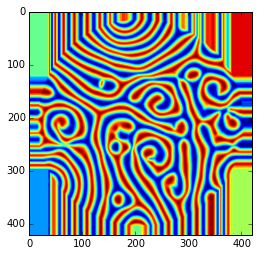

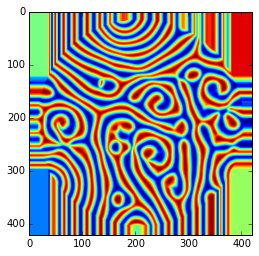

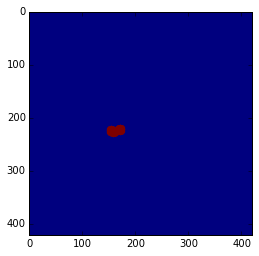

In [16]:
plt.imshow(prev_im.bmp)
plt.show()
plt.imshow(im.bmp)
plt.show()
plt.imshow(im.high_velocity_points)
plt.show()

## Identify Peaks in Lyapunov Vector

The following code locates the actual "peaks" in a Lyapunov vector, minimizing the number of "echoes" while keeping low-valued peaks.

In [17]:
def get_lyapunov_peaks(bmp, peak_cutoff, blur_radius, diff_cutoff, radius):

    # Compute the average
    lyap_average = lyap.copy()
    kernel = np.zeros((blur_radius*2, blur_radius*2))
    kernel[blur_radius, blur_radius] = 1.
    kernel = morph.binary_dilation(morph.disk(blur_radius))
    lyap_average = scipy.ndimage.convolve(lyap_average, kernel, mode='constant', cval=0.0)

    # Get the regions where the difference between the original and the averaged are above the cutoff
    lyap_diff = lyap - lyap_average/np.sum(kernel)
    divisor = lyap_average.copy()
    divisor[divisor <= 0.05] = 1
    lyap_diff = np.divide(lyap_diff, divisor)*100.
    lyap_diff = lyap_diff + (lyap>=peak_cutoff).astype(np.int)
    lyap_thresh = (lyap_diff >= diff_cutoff).astype(np.int)
    lyap_thresh = np.multiply(lyap_thresh, lyap)

    # Dilate selected regions by the radius given
    lyap_thresh = morph.dilation(lyap_thresh, morph.disk(radius))

    return lyap_thresh


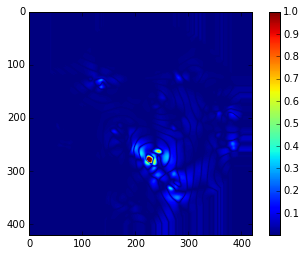

<matplotlib.colorbar.Colorbar instance at 0x111d8c320>

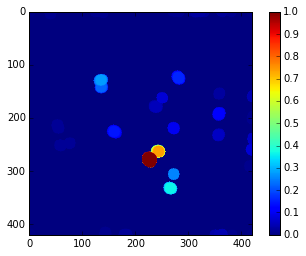

In [18]:
# Lyapunov peak selection parameters
lyap_peak_cutoff = 0.8   # Include all pixels in Lyapunov vector above this threshold
lyap_blur_radius = 12    # For smoothing out the "echos"
lyap_diff_cutoff = 0.4   # Average difference threshold
lyap_radius = 10         # Dilation radius for Lyapunov peak

# Load Lyapunov vector magnitude data
lyap = load_lyap_data(myproject, idx)

# Normalize to [0,1]
lyap = lyap.astype(np.float)/255.

# Get the peaks
lyap_peaks = get_lyapunov_peaks(lyap, lyap_peak_cutoff, lyap_blur_radius,
                               lyap_diff_cutoff, lyap_radius)


# Plot the Lyapunov vector and its identified peaks
plt.imshow(lyap)
plt.colorbar()
plt.show()
plt.imshow(lyap_peaks)
plt.colorbar()

## Generate Precision-Recall Curves

The following code is used to generate the data for a precision recall curve for a single defect type and Lyapunov vector, where the height of the Lypunov peak is the value varied.

In [19]:

def get_probability_values(A, B, area):
    p_AB = float(np.sum(np.multiply(A, B)))/area
    p_A = float(np.sum(A))/area
    p_B = float(np.sum(B))/area
    
    return (p_AB, p_A, p_B)
    

def plot_series(df, plot_title, filename):
    
    plot_data = pd.DataFrame(lyap_pr_thresholds, columns = ['Threshold'])
    plot_data["LF"] = 0.
    plot_data["FL"] = 0.
    plot_data["F"] = 0.
    plot_data["L"] = 0.

    
    for threshold in lyap_pr_thresholds:
        
        df_thresh = df.loc[df['Threshold']==threshold].copy()

        plot_data.loc[plot_data.Threshold == threshold, 'LF'] = (df_thresh.LF/df_thresh.F).mean()
        plot_data.loc[plot_data.Threshold == threshold, 'FL'] = (df_thresh.LF/df_thresh.L).mean()
        plot_data.loc[plot_data.Threshold == threshold, 'F'] = df_thresh.F.mean()
        plot_data.loc[plot_data.Threshold == threshold, 'L'] = df_thresh.L.mean()
        
    
    plt.plot(plot_data.LF, plot_data.FL)
    plt.scatter(plot_data.LF, plot_data.FL, s=40, c=plot_data.Threshold, edgecolors=None)
    plt.colorbar()
    plt.title(plot_title)
    plt.xlabel('Precision: P(L|F); P(L)')
    plt.ylabel('Recall: P(F|L); P(F)')
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    plt.plot(plot_data.L, plot_data.F)
    plt.scatter(plot_data.L, plot_data.F, s=20, c=plot_data.Threshold, edgecolors=None)

#     plt.savefig(myproject['directory'] + '/' + myproject['additional_data']['lyap_stats_plots_out'] + filename)
    
    plt.show()

    plt.clf()

    
def make_plots():
    plt.rcParams['figure.figsize'] = (5.0, 5.0) 
    plt.rcParams.update({'font.size': 16})

    df_types = ['disclination-concave', 'disclination-convex', 'dislocation pair',
                'grain boundary', 'target', 'spiral', 
                'td', 'pinch-off', 'emerging-target', 'td*', 'wn_low', 'wn_high']
    for df_type in df_types:
        plot_series(independence_analysis[df_type], 
                    '%s  def rad: %d  lyap rad= %d' % (df_type, radius, lyap_radius), 
                    'peak_cutoff_%s_%d_%d.png' % (df_type, radius, lyap_radius))

    for derivative in derivatives:
        plot_series(independence_analysis['temp-derivative'][derivative], 
                    '%d deriv  Cutoff: %d  Radius= %d' % (derivative, derivative_cutoff, lyap_radius), 
                    'peak_cutoff_d%d_%d_%d_%d.png' % (derivative, derivative_cutoff, radius, lyap_radius))



In [20]:
# Parameters for generating all of the precision recall curves
process_range = range(100, 3500)

# Defect radius
radius = 10

# Topological defects
sigma = 3

# Plumes/saddles
lowercutoff = 45
uppercutoff = 200
delta = 10

# Wavenumber
wn_cutoff = 3.
wn_cutoff_low = 1.7

# Topological Defects with Velocity
distance_cutoff = 7. # Beyond this radius, considered unmatched
high_velocity = 4. # Beyond this velocity, considered "fast"

# Lyapunov peak selection
lyap_peak_cutoff = 0.8
lyap_blur_radius = 12
lyap_diff_cutoff = 0.5
lyap_radius = 5

# Temperature field derivative
num_derivatives = 3
derivatives = range ( 1, num_derivatives + 1)
derivative_cutoff = 40


# Peak thresholds for generating the precision-recall curves
lyap_pr_thresholds = [x*0.05 for x in range(1, 20+1)] # the thresholds for the precision/recall curves



# Independence analysis
independence_analysis = {}

# Initialize probabilities
df_types = ['disclination-concave', 'disclination-convex', 'dislocation pair',
            'grain boundary', 'target', 'spiral', 
            'td', 'pinch-off', 'emerging-target', 'td*', 'wn_low', 'wn_high']

for defect in df_types:
    independence_analysis[defect] = []

independence_analysis['temp-derivative'] = {}
for derivative in derivatives:
    independence_analysis['temp-derivative'][derivative] = []


# Initialize indicator functions
indicators = {}

# Other useful stuff
c = cropping_region()
total_area = float(np.sum(c))

# Previous topological defects (for velocity)
prev_im = load_image_data(myproject, idx - 1)
prev_im = get_topological_defects(prev_im, sigma)
prev_td = prev_im.orientation_fields[sigma].topological_defects_list.copy()

# Initialize previous images (for derivatives)
prev_imgs = range(num_derivatives+1)
for derivative in derivatives:
    prev_imgs[derivative] =  load_image_data(myproject, idx - derivative).bmp.copy().astype(np.float)

# Loop through all of the indices and collect the stats
for idx in process_range:
    
    if idx % 10 == 0:
        print idx
    
    # Initialize the image object
    im = load_image_data(myproject, idx)
    
    # Get canonical defects
    im = get_canonical_defects(im, sigma, radius, delta)
    
    # Compute the local wavenumber
    im = get_local_wavenumber(im)

    # Compute derivatives
    im.prev_imgs = prev_imgs
    im.prev_imgs[0] = im.bmp.copy().astype(np.float)
    im = get_derivatives(im, derivatives)
    
    # Get pinch-offs and emerging targets
    im = get_pinch_offs(im, lowercutoff, uppercutoff, delta, radius)
    im = get_emerging_targets(im, lowercutoff, uppercutoff, delta, radius)

    # Get indicator function for high velocities
    td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, prev_td, distance_cutoff)
    td_with_velocities = td_with_velocities.loc[(td_with_velocities['velocity'] >= high_velocity)]
    td_high_velocity_points = np.zeros(im.bmp.shape)
    td_high_velocity_points[td_with_velocities['row'], td_with_velocities['col']] = 1

    # Load Lyapunov vector magnitude data and compute peaks
    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.float)/255.
    lyap_peaks = get_lyapunov_peaks(lyap, lyap_peak_cutoff, lyap_blur_radius,
                                   lyap_diff_cutoff, lyap_radius)

    # Crop everything into a circular region
    im.bmp = np.multiply(im.bmp, c)
    im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1]) # Set outer boundary of wave number to the median
    lyap_peaks = np.multiply(lyap_peaks, c)
  
    # Initialize indicator dictionary
    indicators = {}
    
    for defect in df_types[0:6]:
        indicators[defect] = np.multiply(im.defect_regions[defect], c)
        
    indicators['td'] = np.multiply(im.orientation_fields[sigma].topological_defects, c)
    indicators['pinch-off'] = np.multiply(im.pinch_offs, c)
    indicators['emerging-target'] = np.multiply(im.emerging_targets, c)
    indicators['td*'] = np.multiply(td_high_velocity_points, c)
    indicators['wn_low'] = np.multiply((im.local_wavenumber >= wn_cutoff).astype(np.int), c)
    indicators['wn_high'] = np.multiply((im.local_wavenumber <= wn_cutoff_low).astype(np.int), c)

    # Get temp derivative indicators
    indicators['temp-derivative'] = {}
    for derivative in derivatives:
        im.derivative[derivative] = np.multiply(im.derivative[derivative], c)
        indicators['temp-derivative'][derivative] = (im.derivative[derivative] >= derivative_cutoff).astype(np.int)
        indicators['temp-derivative'][derivative] = morph.dilation(indicators['temp-derivative'][derivative], morph.disk(radius))
        indicators['temp-derivative'][derivative] = np.multiply(indicators['temp-derivative'][derivative], c)
        
        
    for lyap_threshold in lyap_pr_thresholds:
        lyap_ind = (lyap_peaks >= lyap_threshold).astype(np.int)

        # Process the probabilities
        for defect in df_types:
            independence_analysis[defect].append([idx] + [lyap_threshold] + list(get_probability_values(lyap_ind, indicators[defect], total_area)))

        for derivative in derivatives:
            independence_analysis['temp-derivative'][derivative].append([idx] + [lyap_threshold] + 
                                list(get_probability_values(lyap_ind, indicators['temp-derivative'][derivative], total_area)))


    prev_td = im.orientation_fields[sigma].topological_defects_list

    for derivative in reversed(derivatives):
        prev_imgs[derivative] = im.prev_imgs[derivative - 1].copy()



100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270


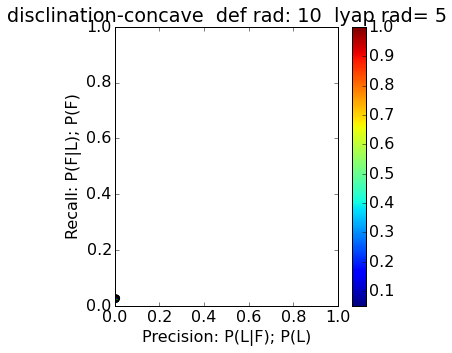

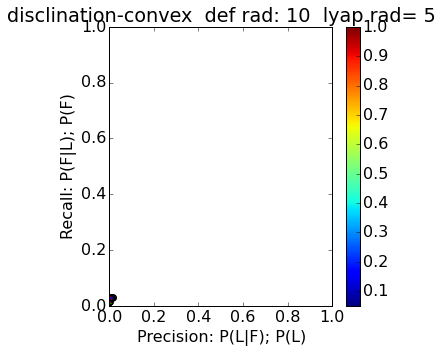

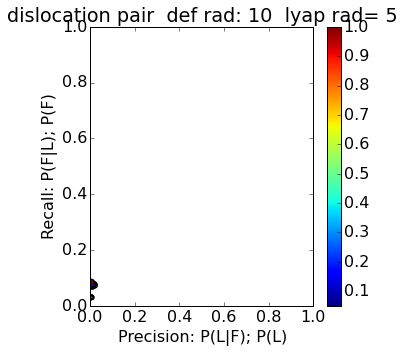

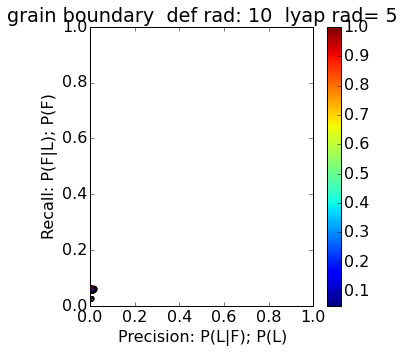

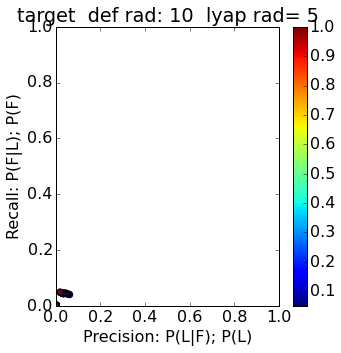

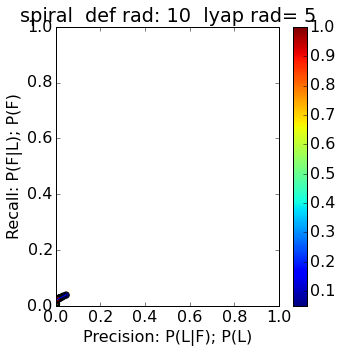

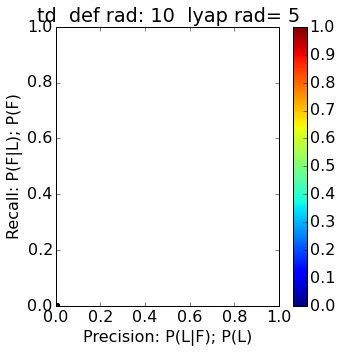

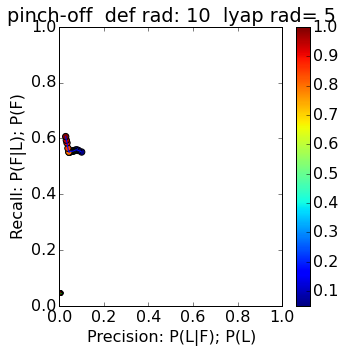

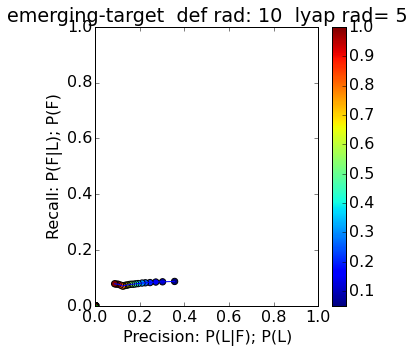

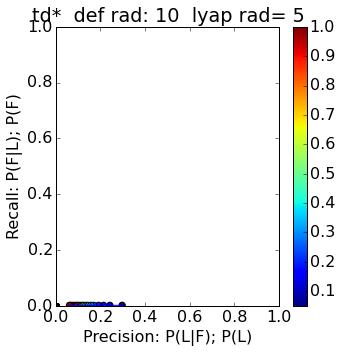

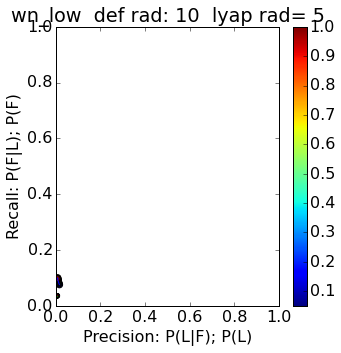

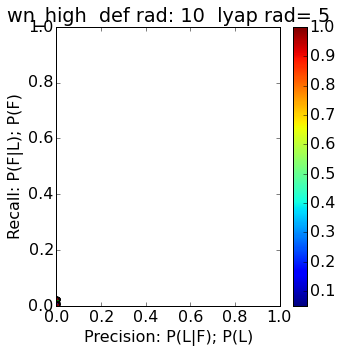

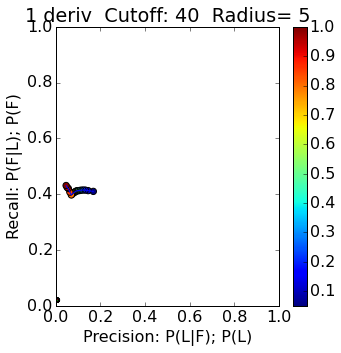

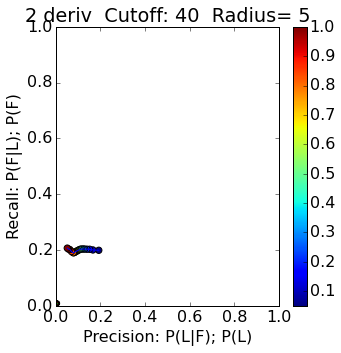

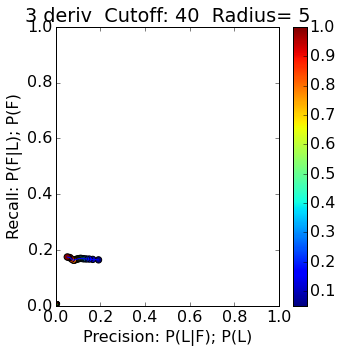

In [21]:


# Convert everything to pandas dataframes
df_columns = ['Frame', 'Threshold', 'LF', 'L', 'F']

# Initialize probabilities
df_types = ['disclination-concave', 'disclination-convex', 'dislocation pair',
            'grain boundary', 'target', 'spiral', 
            'td', 'pinch-off', 'emerging-target', 'td*', 'wn_low', 'wn_high']
for df_type in df_types:
    independence_analysis[df_type] = pd.DataFrame(independence_analysis[df_type], columns = df_columns)

for derivative in derivatives:
    independence_analysis['temp-derivative'][derivative] = pd.DataFrame(independence_analysis['temp-derivative'][derivative], columns = df_columns)

make_plots()

